In [2]:
cd

'c:\\Users\\bruno\\Downloads\\github_tfg\\Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\\GANWriting'

Vocab size: 81
Tokens: {'PAD_TOKEN': 0, 'SOS_TOKEN': 1, 'EOS_TOKEN': 2, 'UNK_TOKEN': 3, '1-8-time': 4, '12-8-time': 5, '2-4-time': 6, '2-8-time': 7, '3-4-time': 8, '3-8-time': 9, '4-2-time': 10, '4-4-time': 11, '4-8-time': 12, '5-4-time': 13, '5-8-time': 14, '6-4-time': 15, '6-8-time': 16, '7-4-time': 17, '8-8-time': 18, '9-8-time': 19, 'accent': 20, 'barline': 21, 'bass': 22, 'beam': 23, 'breve': 24, 'c-clef': 25, 'chord': 26, 'common-time': 27, 'crotchet': 28, 'cut-time': 29, 'demisemiquaver_line': 30, 'dot': 31, 'double-whole-rest': 32, 'eighth-grace-note': 33, 'eighth-note': 34, 'eighth-rest': 35, 'f-clef': 36, 'fermata': 37, 'flat': 38, 'g-clef': 39, 'glissando': 40, 'half-note': 41, 'marcato': 42, 'minim': 43, 'mordent': 44, 'multiple-eighth-notes': 45, 'multiple-half-notes': 46, 'multiple-quarter-notes': 47, 'multiple-sixteenth-notes': 48, 'natural': 49, 'other': 50, 'quarter-note': 51, 'quarter-rest': 52, 'quaver_br': 53, 'quaver_line': 54, 'quaver_tr': 55, 'repeat-measure': 56

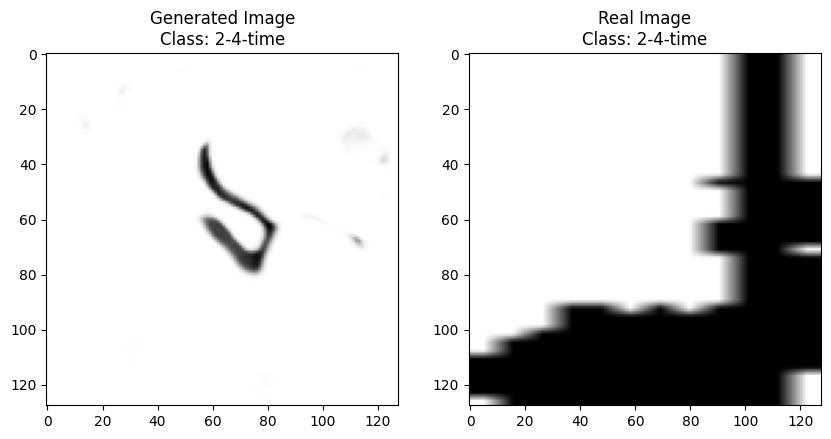

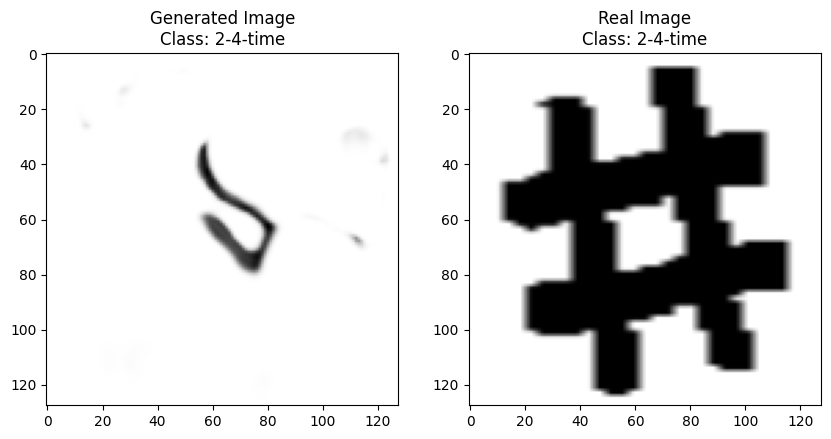

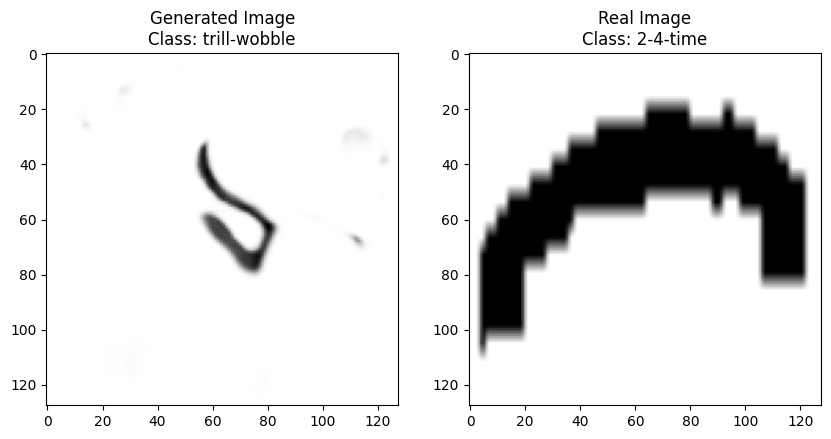

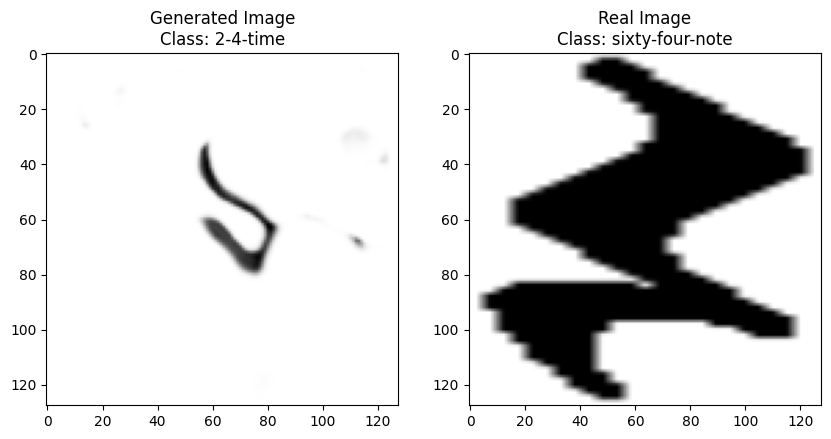

In [22]:
import os
import torch
import random
import matplotlib.pyplot as plt
from load_data import loadData as load_data_func, vocab_size, IMG_WIDTH, IMG_HEIGHT, tokens, index2letter
from network_tro import ConTranModel
from modules_tro import write_image
from PIL import Image
from torchvision import transforms

device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')

def load_model(model_path, show_iter_num, oov):
    model = ConTranModel(show_iter_num, oov).to(device)
    state_dict = torch.load(model_path, map_location=device)  # Carga el state_dict desde el archivo
    # Filtrar claves innecesarias y ajustar el tamaño
    state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict() and v.size() == model.state_dict()[k].size()}
    model.load_state_dict(state_dict, strict=False)  # Carga el state_dict en el modelo
    model.eval()  # Configura el modelo en modo evaluación
    return model

def get_random_real_image_path(class_dir):
    if not os.path.isdir(class_dir):
        print(f"Directorio {class_dir} no encontrado.")
        return None
    image_files = [f for f in os.listdir(class_dir) if f.endswith('.png')]
    if not image_files:
        print(f"No se encontraron imágenes en {class_dir}.")
        return None
    random_image = random.choice(image_files)
    return os.path.join(class_dir, random_image)

def classify_image(model, img_tensor):
    with torch.no_grad():
        pred_logits = model.rec(img_tensor, torch.tensor([[tokens['SOS_TOKEN']]]).to(device), img_width=torch.tensor([IMG_WIDTH]).to(device))
        pred_label_idx = torch.argmax(pred_logits, dim=-1).cpu().numpy().flatten()
        pred_label = ''.join([index2letter[idx] for idx in pred_label_idx if idx in index2letter])
    return pred_label

def generate_and_compare(model, symbol, real_image_path):
    symbol_key = symbol.lower().replace('_', '-')
    symbol_idx = tokens.get(symbol_key)
    if symbol_idx is None:
        print(f"Símbolo {symbol} no encontrado en el diccionario.")
        return

    # Crear una imagen de entrada ficticia para generar el símbolo
    dummy_img = torch.randn(1, 1, IMG_HEIGHT, IMG_WIDTH).to(device)
    generated_img = model.gen(dummy_img)

    # Clasificar la imagen generada
    generated_label = classify_image(model, generated_img)

    # Cargar imagen real
    real_image = Image.open(real_image_path).convert('L')
    transform = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor()
    ])
    real_image = transform(real_image).unsqueeze(0).to(device)

    # Clasificar la imagen real
    real_label = classify_image(model, real_image)

    # Mostrar imágenes con etiquetas
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(generated_img.squeeze().cpu().detach().numpy(), cmap='gray')
    axes[0].set_title(f'Generated Image\nClass: {generated_label}')
    axes[1].imshow(real_image.squeeze().cpu().detach().numpy(), cmap='gray')
    axes[1].set_title(f'Real Image\nClass: {real_label}')
    plt.show()

if __name__ == '__main__':
    base_dir = 'C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems'
    model_path = os.path.join(base_dir, 'save_weights/contran-44.model')  # Reemplaza con la ruta real
    show_iter_num = 1
    oov = True

    # Verificar el vocab_size y tokens
    print(f"Vocab size: {vocab_size}")
    print(f"Tokens: {tokens}")

    model = load_model(model_path, show_iter_num, oov)

    # Directorios y clases
    test_symbols = {
        'quarter_note': os.path.join(base_dir, 'dataset1/Quarter-Note'),
        'sharp': os.path.join(base_dir, 'dataset1/Sharp'),
        'tie_slur': os.path.join(base_dir, 'dataset1/Tie-Slur'),
        'quarter_rest': os.path.join(base_dir, 'dataset1/Quarter-Rest')
    }

    for symbol, class_dir in test_symbols.items():
        real_image_path = get_random_real_image_path(class_dir)
        if real_image_path:
            generate_and_compare(model, symbol, real_image_path)


Vocab size: 81
Tokens: {'PAD_TOKEN': 0, 'SOS_TOKEN': 1, 'EOS_TOKEN': 2, 'UNK_TOKEN': 3, '1-8-time': 4, '12-8-time': 5, '2-4-time': 6, '2-8-time': 7, '3-4-time': 8, '3-8-time': 9, '4-2-time': 10, '4-4-time': 11, '4-8-time': 12, '5-4-time': 13, '5-8-time': 14, '6-4-time': 15, '6-8-time': 16, '7-4-time': 17, '8-8-time': 18, '9-8-time': 19, 'accent': 20, 'barline': 21, 'bass': 22, 'beam': 23, 'breve': 24, 'c-clef': 25, 'chord': 26, 'common-time': 27, 'crotchet': 28, 'cut-time': 29, 'demisemiquaver_line': 30, 'dot': 31, 'double-whole-rest': 32, 'eighth-grace-note': 33, 'eighth-note': 34, 'eighth-rest': 35, 'f-clef': 36, 'fermata': 37, 'flat': 38, 'g-clef': 39, 'glissando': 40, 'half-note': 41, 'marcato': 42, 'minim': 43, 'mordent': 44, 'multiple-eighth-notes': 45, 'multiple-half-notes': 46, 'multiple-quarter-notes': 47, 'multiple-sixteenth-notes': 48, 'natural': 49, 'other': 50, 'quarter-note': 51, 'quarter-rest': 52, 'quaver_br': 53, 'quaver_line': 54, 'quaver_tr': 55, 'repeat-measure': 56

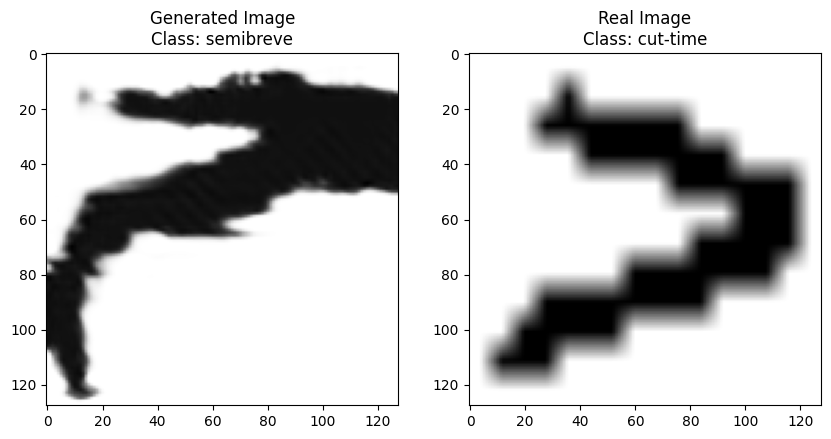

Generating and comparing for symbol: barline


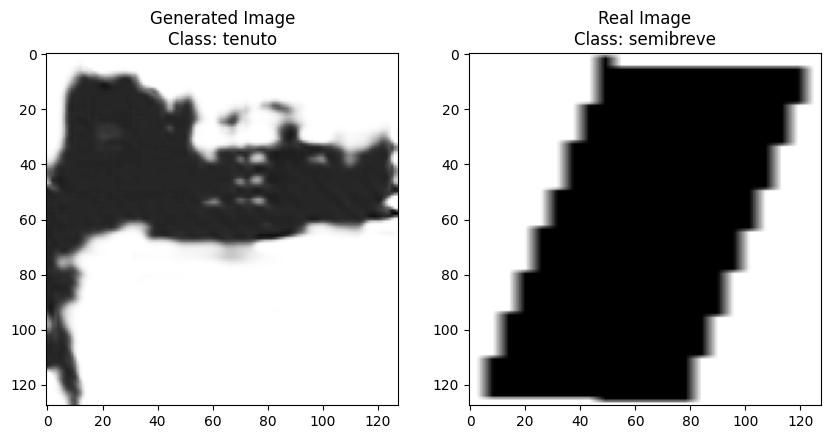

Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/bass no encontrado.
No real image found for symbol: bass
Generating and comparing for symbol: beam


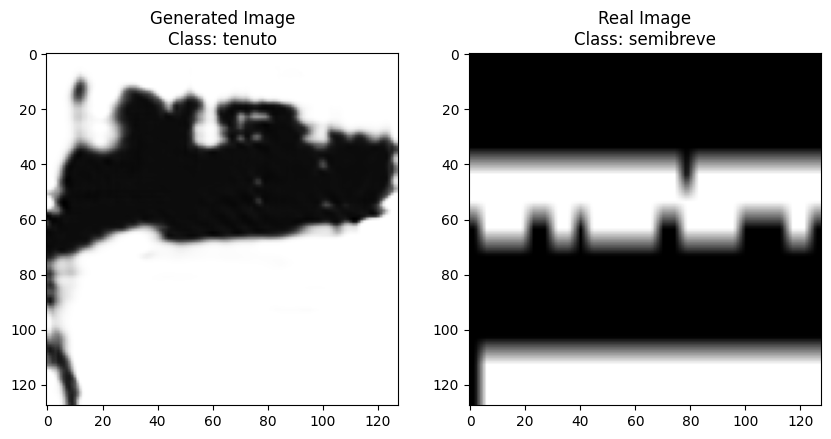

Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/breve no encontrado.
No real image found for symbol: breve
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/c_clef no encontrado.
No real image found for symbol: c-clef
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/chord no encontrado.
No real image found for symbol: chord
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/common_time no encontrado.
No real image found for symbol: common-time
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/crotchet no encontrado.
No real image found for symbol: crot

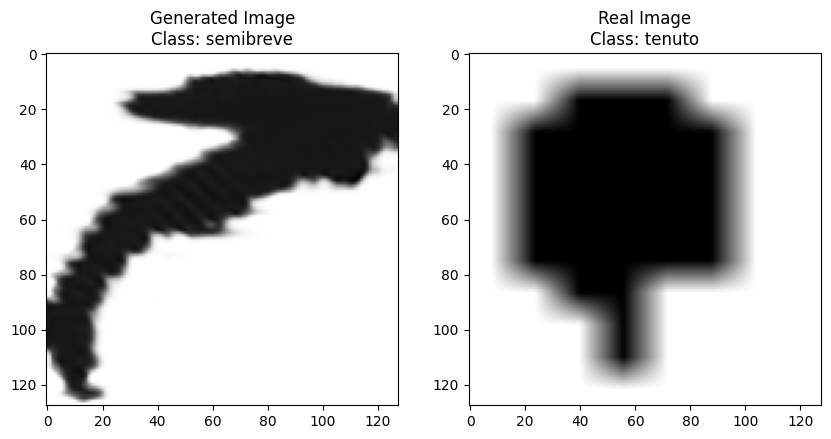

Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/double_whole_rest no encontrado.
No real image found for symbol: double-whole-rest
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/eighth_grace_note no encontrado.
No real image found for symbol: eighth-grace-note
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/eighth_note no encontrado.
No real image found for symbol: eighth-note
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/eighth_rest no encontrado.
No real image found for symbol: eighth-rest
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/f_

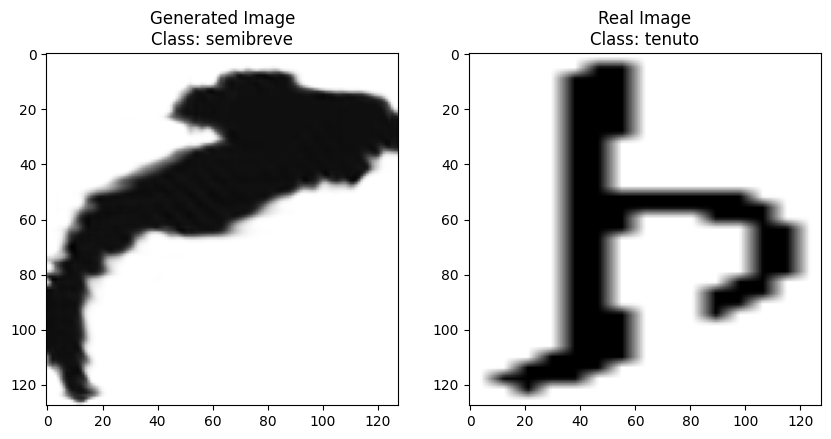

Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/g_clef no encontrado.
No real image found for symbol: g-clef
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/glissando no encontrado.
No real image found for symbol: glissando
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/half_note no encontrado.
No real image found for symbol: half-note
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/marcato no encontrado.
No real image found for symbol: marcato
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/minim no encontrado.
No real image found for symbol:

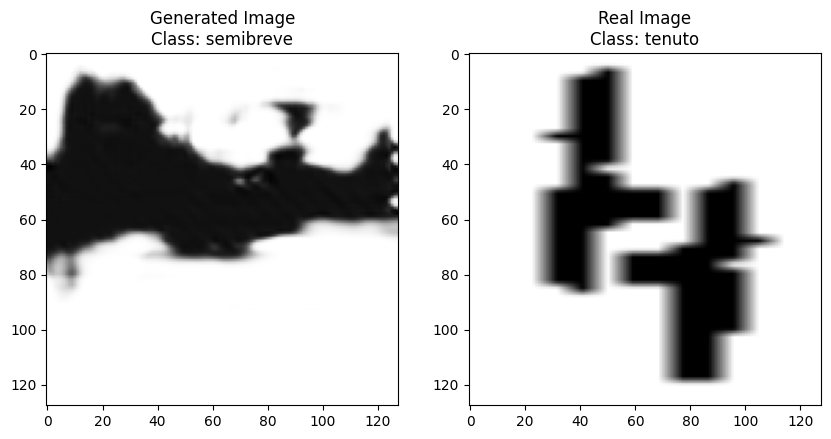

Generating and comparing for symbol: other


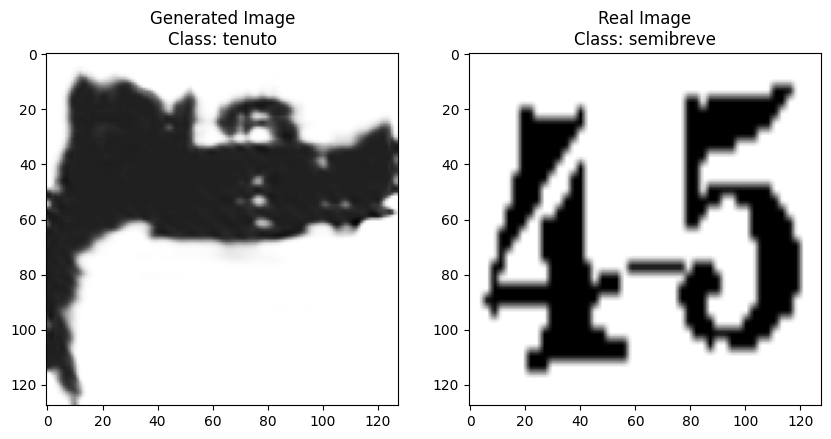

Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/quarter_note no encontrado.
No real image found for symbol: quarter-note
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/quarter_rest no encontrado.
No real image found for symbol: quarter-rest
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/quaver_br no encontrado.
No real image found for symbol: quaver_br
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/quaver_line no encontrado.
No real image found for symbol: quaver_line
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/quaver_tr no encontrado.
N

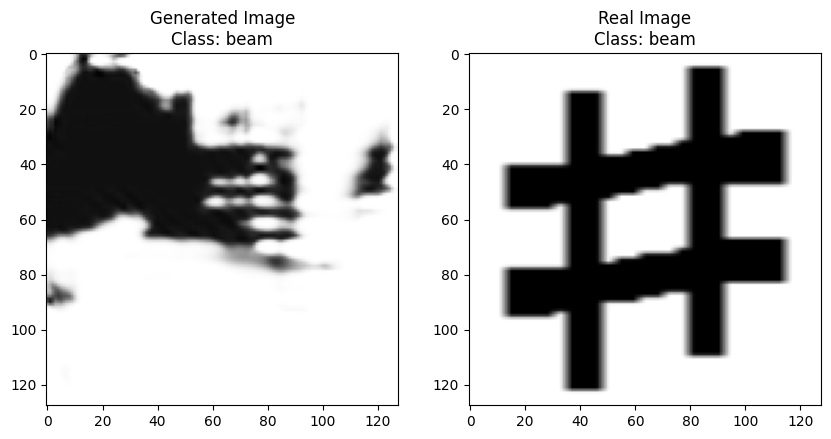

Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/sixteenth_note no encontrado.
No real image found for symbol: sixteenth-note
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/sixteenth_rest no encontrado.
No real image found for symbol: sixteenth-rest
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/sixty_four_note no encontrado.
No real image found for symbol: sixty-four-note
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/sixty_four_rest no encontrado.
No real image found for symbol: sixty-four-rest
Generating and comparing for symbol: staccatissimo


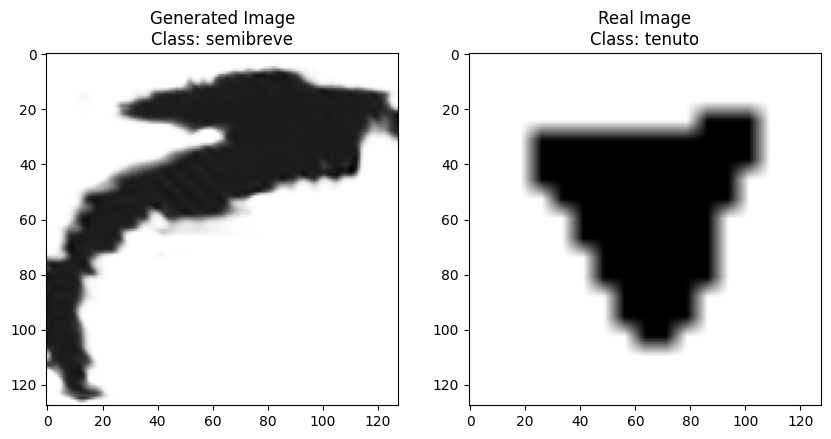

Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/stopped no encontrado.
No real image found for symbol: stopped
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/tenuto no encontrado.
No real image found for symbol: tenuto
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/thirty_two_note no encontrado.
No real image found for symbol: thirty-two-note
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/thirty_two_rest no encontrado.
No real image found for symbol: thirty-two-rest
Directorio C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems\dataset1/tie_slur no encontrado.
No r

In [24]:
import os
import torch
import random
import matplotlib.pyplot as plt
from load_data import loadData as load_data_func, vocab_size, IMG_WIDTH, IMG_HEIGHT, tokens, index2letter
from network_tro import ConTranModel
from modules_tro import write_image
from PIL import Image
from torchvision import transforms

device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')

def load_model(model_path, show_iter_num, oov):
    model = ConTranModel(show_iter_num, oov).to(device)
    state_dict = torch.load(model_path, map_location=device)  # Carga el state_dict desde el archivo
    # Filtrar claves innecesarias y ajustar el tamaño
    state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict() and v.size() == model.state_dict()[k].size()}
    model.load_state_dict(state_dict, strict=False)  # Carga el state_dict en el modelo
    model.eval()  # Configura el modelo en modo evaluación
    return model

def get_random_real_image_path(class_name, base_dirs):
    image_files = []
    for base_dir in base_dirs:
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            image_files += [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith('.png')]
    if not image_files:
        print(f"No se encontraron imágenes en las rutas: {base_dirs}")
        return None
    return random.choice(image_files)

def classify_image(model, img_tensor):
    with torch.no_grad():
        pred_logits = model.rec(img_tensor, torch.tensor([[tokens['SOS_TOKEN']]]).to(device), img_width=torch.tensor([IMG_WIDTH]).to(device))
        pred_label_idx = torch.argmax(pred_logits, dim=-1).cpu().numpy().flatten()
        pred_label = ''.join([index2letter[idx] for idx in pred_label_idx if idx in index2letter])
    return pred_label

def generate_image(model):
    # Crear un tensor de entrada ficticio para generar el símbolo
    dummy_img = torch.randn(1, 1, IMG_HEIGHT, IMG_WIDTH).to(device)
    generated_img = model.gen(dummy_img)
    return generated_img

def generate_and_compare(model, symbol, real_image_path):
    # Generar la imagen del símbolo específico
    generated_img = generate_image(model)

    # Clasificar la imagen generada
    generated_label = classify_image(model, generated_img)

    # Cargar imagen real
    real_image = Image.open(real_image_path).convert('L')
    transform = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor()
    ])
    real_image = transform(real_image).unsqueeze(0).to(device)

    # Clasificar la imagen real
    real_label = classify_image(model, real_image)

    # Mostrar imágenes con etiquetas
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(generated_img.squeeze().cpu().detach().numpy(), cmap='gray')
    axes[0].set_title(f'Generated Image\nClass: {generated_label}')
    axes[1].imshow(real_image.squeeze().cpu().detach().numpy(), cmap='gray')
    axes[1].set_title(f'Real Image\nClass: {real_label}')
    plt.show()

if __name__ == '__main__':
    base_dirs = [
        'C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems/dataset1',
        'C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems/dataset2',
        'C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems/data/open_omr_raw',
        'C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems/data/images',
        'C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems/data/muscima_pp_raw'
    ]
    model_path = 'C:/Users/bruno/Downloads/github_tfg/Creation-of-synthetic-images-with-Generative-Adversarial-Networks-for-OMR-systems/save_weights/contran-44.model'  # Reemplaza con la ruta real
    show_iter_num = 1
    oov = True

    # Verificar el vocab_size y tokens
    print(f"Vocab size: {vocab_size}")
    print(f"Tokens: {tokens}")

    model = load_model(model_path, show_iter_num, oov)

    for symbol in tokens:
        if symbol in ['PAD_TOKEN', 'SOS_TOKEN', 'EOS_TOKEN', 'UNK_TOKEN']:
            continue  # Saltar los tokens especiales

        symbol_key = symbol.replace('-', '_')
        real_image_path = get_random_real_image_path(symbol_key, base_dirs)

        if real_image_path:
            print(f'Generating and comparing for symbol: {symbol}')
            generate_and_compare(model, symbol, real_image_path)
        else:
            print(f'No real image found for symbol: {symbol}')
